<a href="https://colab.research.google.com/github/juniaufmg/previsao_0_casos/blob/main/Predicao_0casos_covid19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Universidade Federal de Minas Gerais

Disciplina: Aprendizado de Máquina 2021.1

Trabalho feito por: Júnia Maísa

LINK: https://youtu.be/l2WGfjb3nkE (YouTube)

https://drive.google.com/drive/folders/1QPa8uGS0Y514jzUfvxJziGZzmoJHnjpK?usp=sharing (Link Alternativo - Google Drive)

https://drive.google.com/file/d/1xdldr5R6t9qPrwvvX_x-gtE45MyY3Y-O/view?usp=sharing (Link do DATASET tratado)



In [ ]:
#Bibliotecas necessarias para o trabalho
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd
import numpy as np
import math
import plotly.graph_objects as Dash
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from pandas import datetime
import math, time
import itertools
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [ ]:
#lendo a planilha de dados tratada com os dados não acumulados de vacinação
df2 = pd.read_csv('/content/drive/My Drive/filename.csv', sep=',')
df2.head()

,Unnamed: 0,quant2,data,quant1
0,0,641,2021-03-13,7468
1,1,197,2021-03-14,1486
2,2,4793,2021-03-15,19403
3,3,4445,2021-03-16,49787
4,4,5738,2021-03-17,43039


#Plotando gráfico dos dados

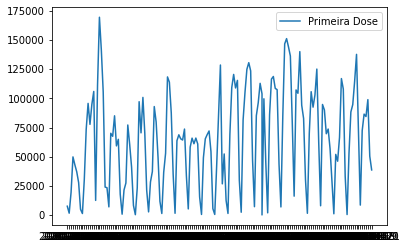

In [ ]:
#plotando grafico para conhecer os dados
#x=df2['data']
#y=df2['quant1']
#plt.plot(x,y, label='Primeira Dose')

x=df2['data']
y=df2['quant1']
plt.plot(x,y,label='Primeira Dose')
plt.legend()

plt.show()

#x=df2['data']
#y=df2['ocupacaoConfirmadoUti']
#plt.plot(x,y, label='Ocupação UTI')

#x=df2['data']
#y=df2['ocupacaoConfirmadoCli']
#plt.plot(x,y, label = 'Ocupação CTI')
#plt.legend()

plt.show()

In [ ]:
df2['data']=pd.to_datetime(df2.data)
df2

,Unnamed: 0,quant2,data,quant1
0,0,641,2021-03-13,7468
1,1,197,2021-03-14,1486
2,2,4793,2021-03-15,19403
3,3,4445,2021-03-16,49787
4,4,5738,2021-03-17,43039
...,...,...,...,...
159,159,47240,2021-08-17,86499
160,160,51504,2021-08-18,84450
161,161,32786,2021-08-19,98928
162,162,34986,2021-08-20,50380


#Aplicando Keras

In [ ]:
#A seguir estamos normalizando os dados de quant1, pois com ele não é necessario
#usar a data ja que vamos usar uma rede neural LSTM para desenvolver
#nossa serie temporal com taxa de amotragem de área.
#lembrando que cada linha do nosso dataset é uma data, ou seja, um dia.
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df2['quant1'].values.reshape(-1, 1))

In [ ]:
#imprimindo normalização
dataset[0:10]

array([[0.0440183 ],
       [0.00875414],
       [0.11437566],
       [0.29349069],
       [0.25371093],
       [0.21798107],
       [0.16344011],
       [0.02849665],
       [0.00706226],
       [0.18033531]])

In [ ]:
# split into train and test sets
#dividindo os dados em treino e teste (70% treino e 30% para teste)
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

114 50


Defino a data de look back como 15 dias, que é o número de etapas de tempo anteriores para usar como variáveis de entrada para prever o próximo período de tempo 

In [ ]:
# convert an array of values into a dataset matrix
#as medidas de impacto do Covid são de 15 dias, por isso, escolhemos um look back de 15 dias
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
#Criando as variaveis de treino de teste
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

A rede LSTM espera que os dados de entrada (X) sejam fornecidos com uma estrutura de array específica na forma de: [amostras, intervalos de tempo, recursos].

Atualmente, esses dados estão no formato: [amostras, recursos] e estamos enquadrando o problema como uma etapa de tempo para cada amostra. Podemos transformar o trem preparado e os dados de entrada de teste na estrutura esperada usando numpy.reshape () da seguinte maneira 

In [ ]:
#Dando formato a variavel de treino e teste
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

#LSTM

A rede Long Short-Term Memory, ou rede LSTM, é uma rede neural recorrente que é treinada usando Backpropagation Through Time e supera o problema do gradiente de desaparecimento.

Como tal, ele pode ser usado para criar grandes redes recorrentes que, por sua vez, podem ser usadas para resolver problemas de sequência difíceis no aprendizado de máquina e obter resultados de última geração.

Em vez de neurônios, as redes LSTM têm blocos de memória que são conectados por meio de camadas.

Um bloco possui componentes que o tornam mais inteligente do que um neurônio clássico e uma memória para sequências recentes. Um bloco contém portas que gerenciam o estado e a saída do bloco. Um bloco opera em uma sequência de entrada e cada porta dentro de um bloco usa as unidades de ativação sigmóide para controlar se elas são disparadas ou não, tornando a mudança de estado e adição de informações que fluem através do bloco condicional.

Existem três tipos de portas dentro de uma unidade:

Forget Gate: decide condicionalmente quais informações jogar fora do bloco. Porta de entrada: decide condicionalmente quais valores da entrada atualizar o estado da memória. Porta de saída: decide condicionalmente o que produzir com base na entrada e na memória do bloco. Cada unidade é como uma mini-máquina de estados onde os portões das unidades possuem pesos que são aprendidos durante o procedimento de treinamento.

A rede tem uma camada visível com 1 entrada, uma camada oculta com 20 blocos LSTM ou neurônios e uma camada de saída que faz uma previsão de 15 valores. A função de ativação sigmóide padrão é usada para os blocos LSTM. A rede é treinada para 20 épocas e um tamanho de lote de 1 é usado. 

In [ ]:
# create and fit the LSTM network
#Criando a rede LSTM
#hiperparametros: LSTM, Dense, optimizer
from keras.models import Sequential
from keras.layers import LSTM, Dense
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
98/98 - 2s - loss: 0.1035
Epoch 2/20
98/98 - 0s - loss: 0.0484
Epoch 3/20
98/98 - 0s - loss: 0.0402
Epoch 4/20
98/98 - 0s - loss: 0.0362
Epoch 5/20
98/98 - 0s - loss: 0.0342
Epoch 6/20
98/98 - 0s - loss: 0.0344
Epoch 7/20
98/98 - 0s - loss: 0.0327
Epoch 8/20
98/98 - 0s - loss: 0.0320
Epoch 9/20
98/98 - 0s - loss: 0.0311
Epoch 10/20
98/98 - 0s - loss: 0.0319
Epoch 11/20
98/98 - 0s - loss: 0.0323
Epoch 12/20
98/98 - 0s - loss: 0.0308
Epoch 13/20
98/98 - 0s - loss: 0.0310
Epoch 14/20
98/98 - 0s - loss: 0.0303
Epoch 15/20
98/98 - 0s - loss: 0.0294
Epoch 16/20
98/98 - 0s - loss: 0.0299
Epoch 17/20
98/98 - 0s - loss: 0.0292
Epoch 18/20
98/98 - 0s - loss: 0.0299
Epoch 19/20
98/98 - 0s - loss: 0.0282
Epoch 20/20
98/98 - 0s - loss: 0.0308


In [ ]:
#Criando o modelo
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# Prevendo os proprios dados de treino
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calcular raiz quadrada média do erro, como é possível ver, ele esta alto.
#mesmo assim, vamos continuar com o modelo
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 27946.14 RMSE
Test Score: 27510.89 RMSE


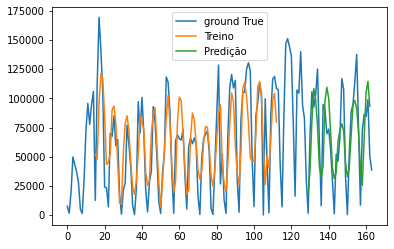

In [ ]:
# Plotando os dados de treinamento e teste
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset),label='ground True')
plt.plot(trainPredictPlot, label='Treino')
plt.plot(testPredictPlot, label='Predição')

plt.legend()
 
plt.show()

RMSE é a medida que calcula a raiz quadratica média dos erros entre valores observados e predições.

Podemos ver no grafico que a previsão dos dados de treino e de teste conseguiram identificar o padrão de nossos dados de entrada, já que a ocilação de subida e descida foi bem parecida em ambos os casos.

Porém, a predição não foi satisfatorio já que os dados de vacinação oscilam durante uma semana, por exemplo: DUrante os finais de semana, acontecem as quedas (minimas) e durante a semana os valores máximos. Com essa ocilação o modelo pode ter aprendido apenas que depois de um certo tempo acontece uma subida e uma descida. 

Para compensaar essa oscilação que acontece durante a semana, podemos fazer como nós jornais informativos de covid19 e aplicar uma media movel nos dados. 

Agora, vamos treinar novamente nosso modelo com uma média movel de 14 dias.


In [ ]:
#Calculo da média móvel: media dos ultimos 14 dias

df2['quant']=df2['quant1'].rolling(14).mean()
df2=df2[df2['quant']>0]

df2

,Unnamed: 0,quant2,data,quant1,quant
13,13,27552,2021-03-26,94879,40301.000000
14,14,3473,2021-03-27,105957,47335.928571
15,15,963,2021-03-28,12454,48119.357143
16,16,18535,2021-03-29,111491,54697.071429
17,17,23492,2021-03-30,169635,63257.642857
...,...,...,...,...,...
159,159,47240,2021-08-17,86499,75304.928571
160,160,51504,2021-08-18,84450,76584.071429
161,161,32786,2021-08-19,98928,75292.785714
162,162,34986,2021-08-20,50380,71176.428571


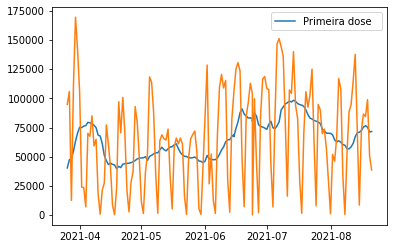

In [ ]:
#plotando o resultado da normalização e comparando com o valor real

x=df2['data']
y=df2['quant']
plt.plot(x,y,label='Primeira dose  ')
plt.legend()
x=df2['data']
y=df2['quant1']
plt.plot(x,y,label='Primeira Dose Real')

plt.show()

No gráfico podemos ver que o valor da media movel acompanha a curva de atualização diaria da vacinação. O módelo compreenderá melhor a taxa de vacinação.

In [ ]:
#Fazendo a normalização dos dados - REPETINDO O PROCESSO
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df2['quant'].values.reshape(-1, 1))




In [ ]:
#diviindo os dados em treino e teste (70% treino e 30% para teste) - REPETINDO O PROCESSO
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

105 46


In [ ]:
# convert an array of values into a dataset matrix
#as medidas de impacto do Covid são de 15 dias, por isso, escolhemos um look back de 15 dias
#- REPETINDO O PROCESSO
def create_dataset(dataset, look_back=15):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
#Criando as variaveis de treino de teste - REPETINDO O PROCESSO
x_train, y_train = create_dataset(train, look_back=15)
x_test, y_test = create_dataset(test, look_back=15)

In [ ]:
#Dando formato a variavel de treino e teste
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [ ]:
# create and fit the LSTM network - REPETINDO O PROCESSO
#Criando a rede LSTM
#hiperparametros: LSTM, Dense, optimizer
from keras.models import Sequential
from keras.layers import LSTM, Dense
look_back = 15
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
89/89 - 1s - loss: 0.0499
Epoch 2/20
89/89 - 0s - loss: 0.0269
Epoch 3/20
89/89 - 0s - loss: 0.0162
Epoch 4/20
89/89 - 0s - loss: 0.0105
Epoch 5/20
89/89 - 0s - loss: 0.0085
Epoch 6/20
89/89 - 0s - loss: 0.0078
Epoch 7/20
89/89 - 0s - loss: 0.0076
Epoch 8/20
89/89 - 0s - loss: 0.0068
Epoch 9/20
89/89 - 0s - loss: 0.0059
Epoch 10/20
89/89 - 0s - loss: 0.0051
Epoch 11/20
89/89 - 0s - loss: 0.0056
Epoch 12/20
89/89 - 0s - loss: 0.0047
Epoch 13/20
89/89 - 0s - loss: 0.0049
Epoch 14/20
89/89 - 0s - loss: 0.0044
Epoch 15/20
89/89 - 0s - loss: 0.0043
Epoch 16/20
89/89 - 0s - loss: 0.0043
Epoch 17/20
89/89 - 0s - loss: 0.0039
Epoch 18/20
89/89 - 0s - loss: 0.0039
Epoch 19/20
89/89 - 0s - loss: 0.0038
Epoch 20/20
89/89 - 0s - loss: 0.0041


No treino do modelo com os dados sem normalização encontramos o menor valor de perda encontrado nas 20 epochs, foi de 0,0283 e no dataset normalizado, a perda, foi de 0.0049. Portanto, a perda foi menor com os dados normalizados. 

In [ ]:
#Criando o modelo
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# Prevendo os proprios dados de treino
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calcular raiz quadrada média do erro. Notamos que ele esta alto.
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3255.75 RMSE
Test Score: 3373.79 RMSE


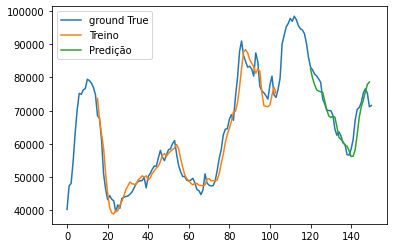

In [ ]:
# PLOTANDO
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(min_max_scaler.inverse_transform(dataset),label='ground True')
plt.plot(trainPredictPlot, label='Treino')
plt.plot(testPredictPlot, label='Predição')

plt.legend()
 
plt.show()

No grafico acima, nota-se que nosso modelo de predição conseguiu acompanha nossos dados normalizados (ground Truth). Indicando que a teoria de tratamento dados para dados de treino e teste, foi valida.

Poderiamos chegar a taxas ainda melhores se houvessemos um periodo de vacinação maior, pois acarretaria em um maior dataset e com isso, mais dados para treino do nosso modelo.

Referências:

https://keras.io/examples/

https://cloud.google.com/ai-platform/docs/getting-started-keras?hl=pt-br

https://scikit-learn.org/

https://www.analyticsvidhya.com/blog/2021/05/analyze-covid-vaccination-progress-using-python/

https://medium.com/turing-talks/turing-talks-27-modelos-de-predição-lstm-df85d87ad210

https://medium.com/turing-talks/turing-talks-27-modelos-de-predição-lstm-df85d87ad210

https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816

https://towardsdatascience.com/time-series-prediction-beyond-test-data-3f4625019fd9

https://towardsdatascience.com/time-series-prediction-beyond-test-data-3f4625019fd9

https://www.kaggle.com/hassanamin/time-series-analysis-using-lstm-keras/notebook

https://www.kite.com/python/answers/how-to-download-a-csv-file-from-a-url-in-python

